# Compare similarity search strategies

In this notebook I am comparing the following similarity search strategies for finding genomic regions with similar peaks:

1. kNN search in the autoencoded latent space
(1b. kNN search in the UMAP 2D embedding of the autoencoded latent space)
2. kNN search in the Euclidean space of the original data
3. kNN search in the DTW space of the original data
4. kNN search in the 2D UMAP embedding of the original data
5. Template-matching with normalized cross correlation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [142]:
import os
import sys
import warnings

# Ignore warnings as they just pollute the output
warnings.filterwarnings('ignore')

# Enable importing modules from the parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../experiments'))
if module_path not in sys.path:
    sys.path.append(module_path)

window_size = 2400
step_size = window_size / 2
resolution = 100

# DNase-seq 2011, hg19
bw = 'data/ENCFF158GBQ.bigWig'
chroms = ['chr22', 'chr1']

## Load and normalize the data

#### Download the data

In [13]:
from download import download_encode_file
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

download_encode_file('ENCFF158GBQ.bigWig')

File already exist. To overwrite pass `overwrite=True`


#### Load models, extract genomic windows, and normalize data

In [221]:
# Load model and data and normalize data

from keras.models import load_model
from server import bigwig

encoder_2_4kb = load_model('../../examples/encode-gm12878-dnase-seq-2011-encoder-2_4kb.h5')
decoder_2_4kb = load_model('../../examples/encode-gm12878-dnase-seq-2011-decoder-2_4kb.h5')

data_2_4kb = bigwig.chunk(
    bw,
    2400,
    resolution,
    2400 / 2,
    [chroms[0]],
    verbose=True,
)

Extracted 42753 windows from chr22 with a max value of 1.0.


In [222]:
data_2_4kb_b = bigwig.chunk(
    bw,
    2400,
    resolution,
    2400 / 2,
    ['chr1', 'chr2', 'chr3'],
    verbose=True,
)

Extracted 207708 windows from chr1 with a max value of 1.0.
Extracted 202666 windows from chr2 with a max value of 1.0.
Extracted 165018 windows from chr3 with a max value of 1.0.


In [ ]:
encoder_12kb = load_model('../../examples/encode-gm12878-chip-seq-h3k27ac-pval-2011-encoder-12kb.h5')
decoder_12kb = load_model('../../examples/encode-gm12878-chip-seq-h3k27ac-pval-2011-decoder-12kb.h5')

data_12kb = bigwig.chunk(
    bw,
    12000,
    100,
    12000 / 6,
    [chroms[1]],
    verbose=True,
)

## Encode data

In [180]:
from ae.utils import predict

predicted_2_4kb, _, latent_2_4kb = predict(
    encoder_2_4kb,
    decoder_2_4kb,
    data_2_4kb.reshape(data_2_4kb.shape[0], data_2_4kb.shape[1], 1)
)

predicted_12kb, _, latent_12kb = predict(
    encoder_12kb,
    decoder_12kb,
    data_12kb.reshape(data_12kb.shape[0], data_12kb.shape[1], 1)
)

## Helper methods

#### Simple kNN search

In [344]:
from scipy.spatial.distance import cdist

def knn(data, target_idx, k, metric='euclidean', sax = None):
    """K nearest neighbors
    
    Find the `k` nearest neighbors of a 
    """
    
    target = data[target_idx]
    
    if sax is None:
        dist = cdist(data, target.reshape((1, target.size)), metric='euclidean').flatten()

    else:
        N = data.shape[0]
        dist = np.zeros(N)
        for i in range(N):
            dist[i] = sax.distance_sax(target, data[i])

    # Ensure that the target is always first
    dist[target_idx] = -1
    
    return np.argsort(dist)[1:n + 1]

#### DTW distance

In [195]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from multiprocessing import Pool

def dtw(data, target_idx: int, n: int, target = None, return_all = False, print_progress: bool = False):
    N = data.shape[0]
    dist = np.zeros(N)
    
    if target is None:
        target = data[target_idx]
        
    p = ((np.arange(4) + 1) * (N // 4)).astype(int)
    
    for i in np.arange(N):
        if i in p and print_progress:
            print('.', end='', flush=True)
        d, _ = fastdtw(data[i], target, dist=euclidean)
        dist[i] = d
    
    if return_all:
        return dist
    
    return np.argsort(dist)[1:n + 1]

def pooled_dtw(data, target_idx: int, n: int, print_progress: bool = False):
    target = data[target_idx]
    mask = np.arange(data.shape[0])
    mask = mask[mask != target_idx]
    data = data[mask]
    
    with Pool() as pool:
        args = [[d, 0, n, target, True, print_progress] for d in np.array_split(data, pool._processes)]
        dist = np.concatenate(pool.starmap(dtw, args))
        
        return np.argsort(dist)[:n]

#### Normalized cross correlation search

In [80]:
from scipy.signal import correlate

def norm(data, zero_norm: bool = False):
    mean = np.mean(data) if zero_norm else 0
    
    return (data - mean) / np.std(data)

def norm2d(data, zero_norm: bool = False):
    mean = np.mean(data, axis=1).reshape(-1, 1) if zero_norm else np.zeros((data.shape[0], 1))
    std = np.std(data, axis=1).reshape(-1, 1)
    
    return (data - mean) / std

def xcrorrelation(data, template_idx, n, normalize=False, zero_normalize=False):
    unknown = data
    template = data[template_idx]
    
    if norm:
        unknown = norm2d(unknown, zero_norm=zero_normalize)
        template = norm(template, zero_norm=zero_normalize)
        
    xcorr = np.apply_along_axis(lambda m: correlate(m, template, mode='full'), axis=1, arr=unknown)
    xcorr[np.where(np.isnan(xcorr))] = 0

    max_xcorr = np.nanmax(xcorr, axis=1)
    return np.argsort(max_xcorr)[::-1][1:n + 1]

## Generate UMAP embeddings of the latent space and original data space

In [37]:
import umap

umap_embedding_2_4kb = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    metric='l2',
).fit_transform(data_2_4kb)

## Find new interesting 2.4kb regions

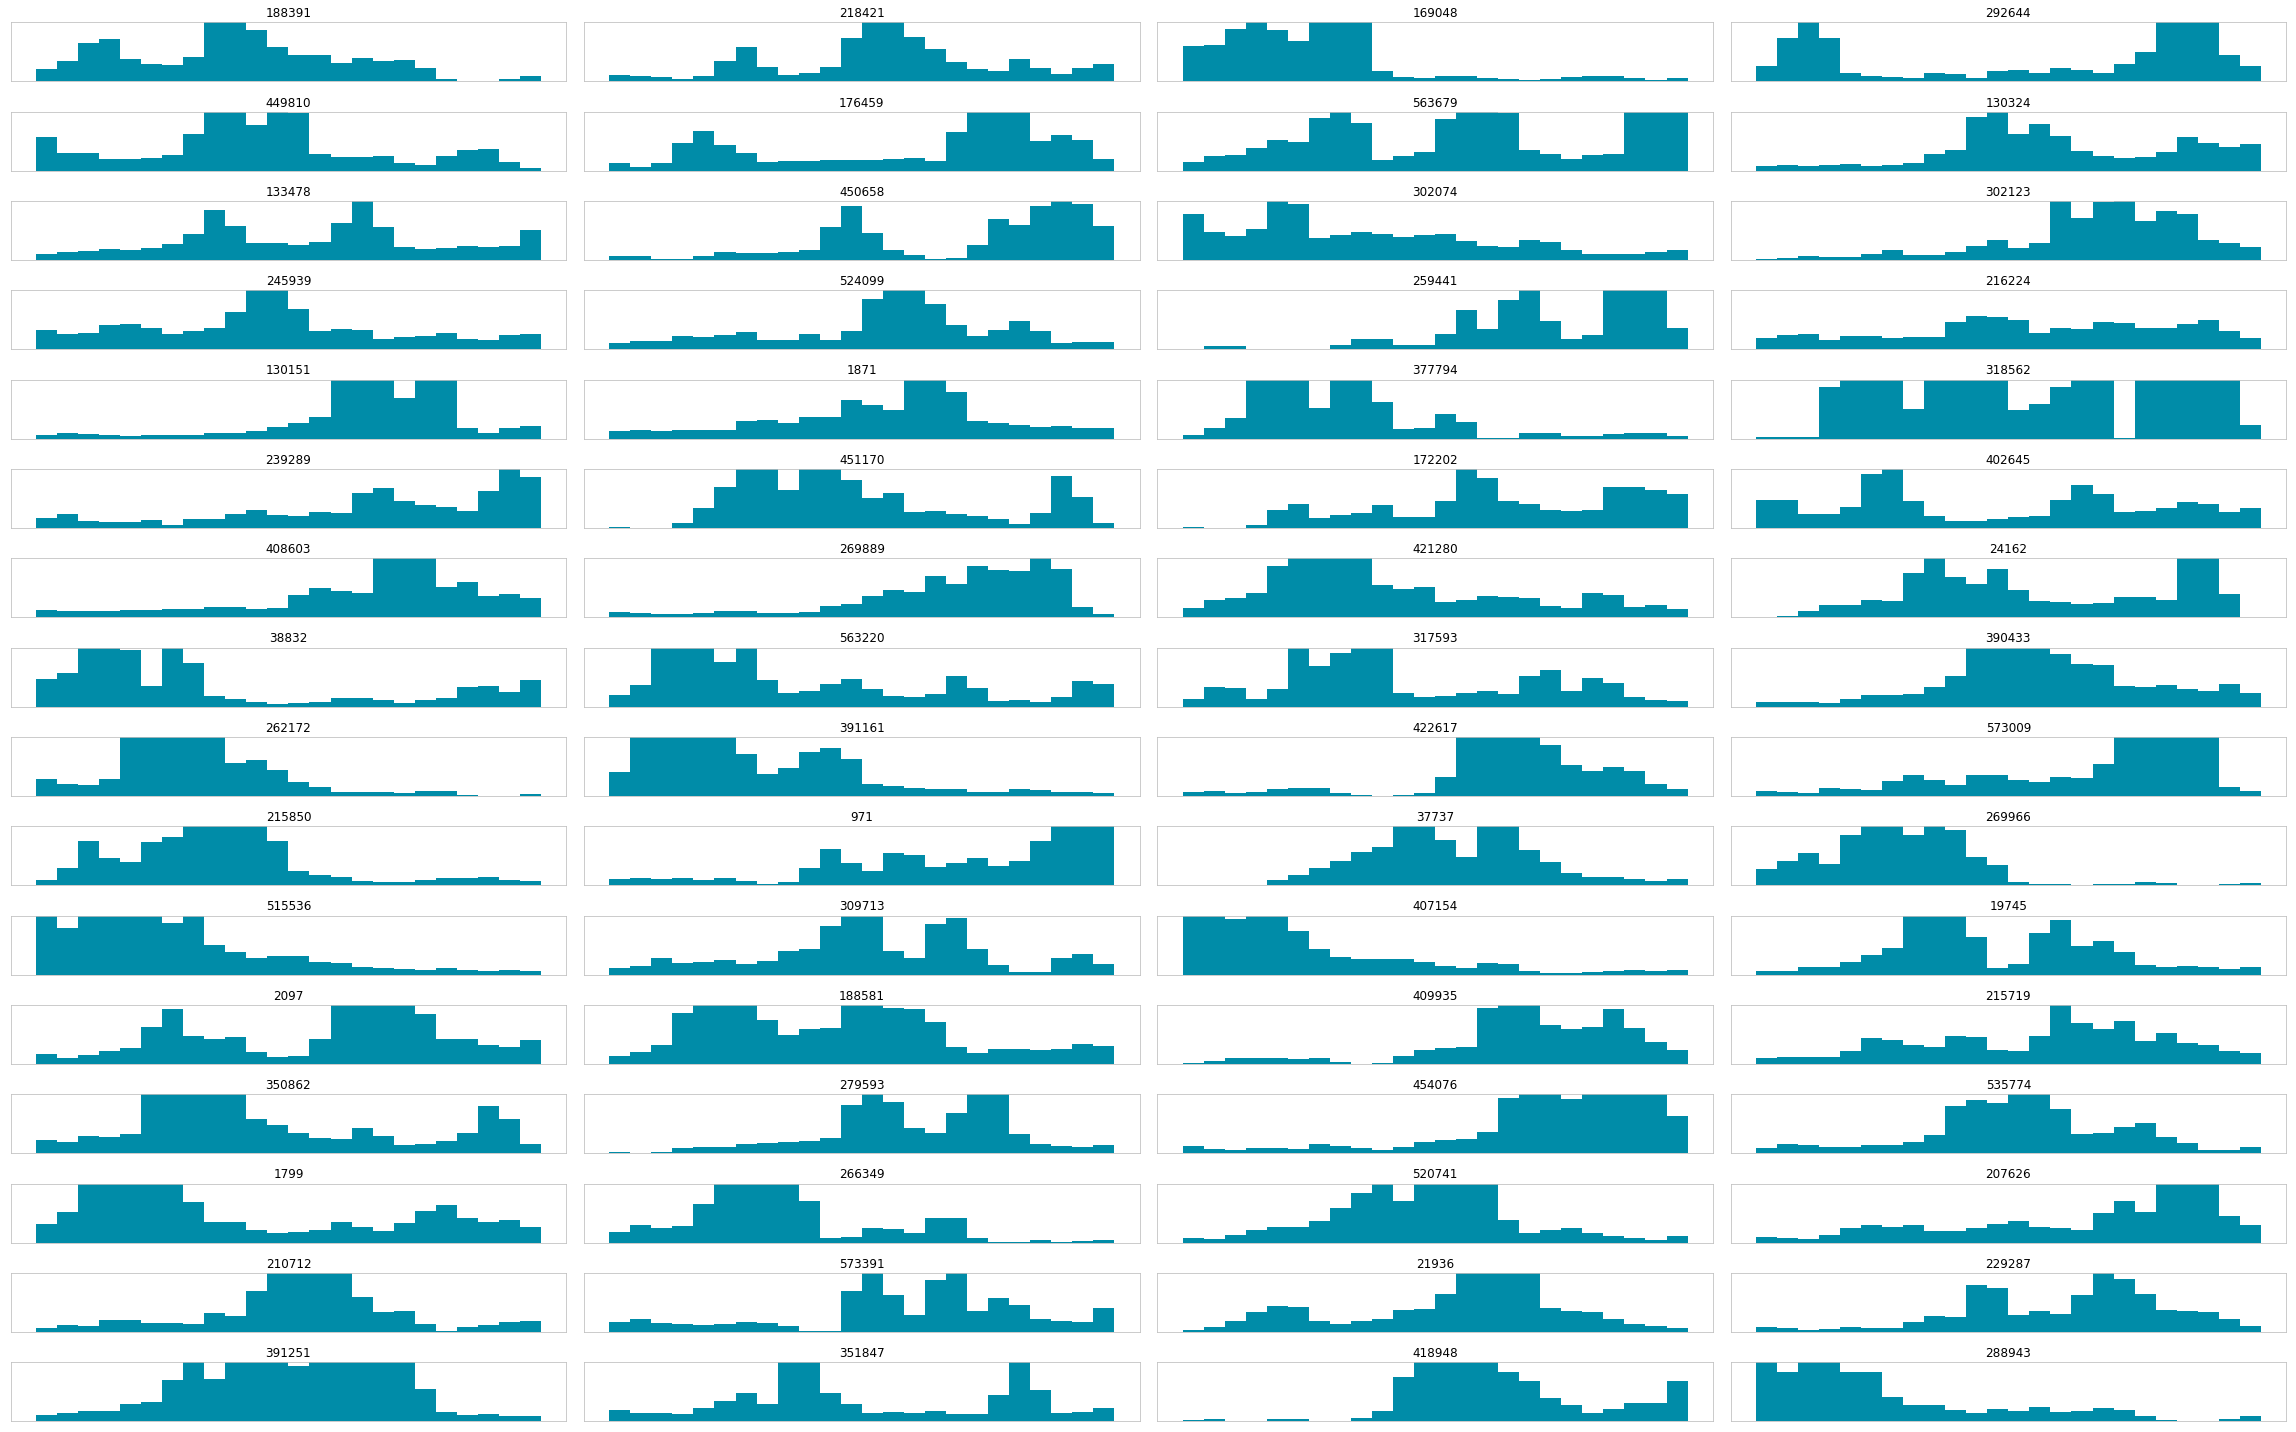

In [223]:
from ae.utils import plot_windows_from_data

num_windows = 64
min_signal = 8

plot_windows_from_data(
    data_2_4kb_b,
    num=num_windows,
    min_signal=min_signal,
)

## 2.4kb Search

In [90]:
# Some genomic windows with interesting peaks
targets = [20196, 26570, 26576, 26790, 26791, 31670, 25513]
k = 5

knn_ae = []
knn_eq = []
knn_dtw = []
knn_umap = []
top_xcross = []

for target in targets:
    print('Search for window #{}'.format(target), end='', flush=True)
    knn_ae.append(knn(latent, target, k))
    print('.', end='', flush=True)
    knn_eq.append(knn(data_test, target, k))
    print('.', end='', flush=True)
    knn_dtw.append(pooled_dtw(data_test, target, k))
    print('.', end='', flush=True)
    knn_umap.append(knn(umap_embedding, target, k))
    print('.', end='', flush=True)
    top_xcross.append(xcrorrelation(data_test, target, k, normalize=True, zero_normalize=True))
    print('. done!')

Search for window #20196..Computing the DTW distance for 42753 windows took 287.4487359523773
... done!
Search for window #26570..Computing the DTW distance for 42753 windows took 279.80624294281006
... done!
Search for window #26576..Computing the DTW distance for 42753 windows took 282.0815329551697
... done!
Search for window #26790..Computing the DTW distance for 42753 windows took 279.5405559539795
... done!
Search for window #26791..Computing the DTW distance for 42753 windows took 276.1450231075287
... done!
Search for window #31670..Computing the DTW distance for 42753 windows took 276.2667832374573
... done!
Search for window #25513..Computing the DTW distance for 42753 windows took 271.9153709411621
... done!


## 2.4kb visual comparison of search strategies

Compare encoding-based knn similarity search strategies against normalize cross correlation.

| Rows  | Description                                      |
|-------|--------------------------------------------------|
| 1     | Search target. Manually picked.                  |
| 2-6   | k-NN in the CAE-based latent space.              |
| 7-11  | k-NN in the Euclide space.                       |
| 11-16 | k-NN on the dynamic time warping space.          |
| 17-21 | k-NN on the UMAP embedded space.                 |
| 21-26 | Zero-normalized cross correlation.               |

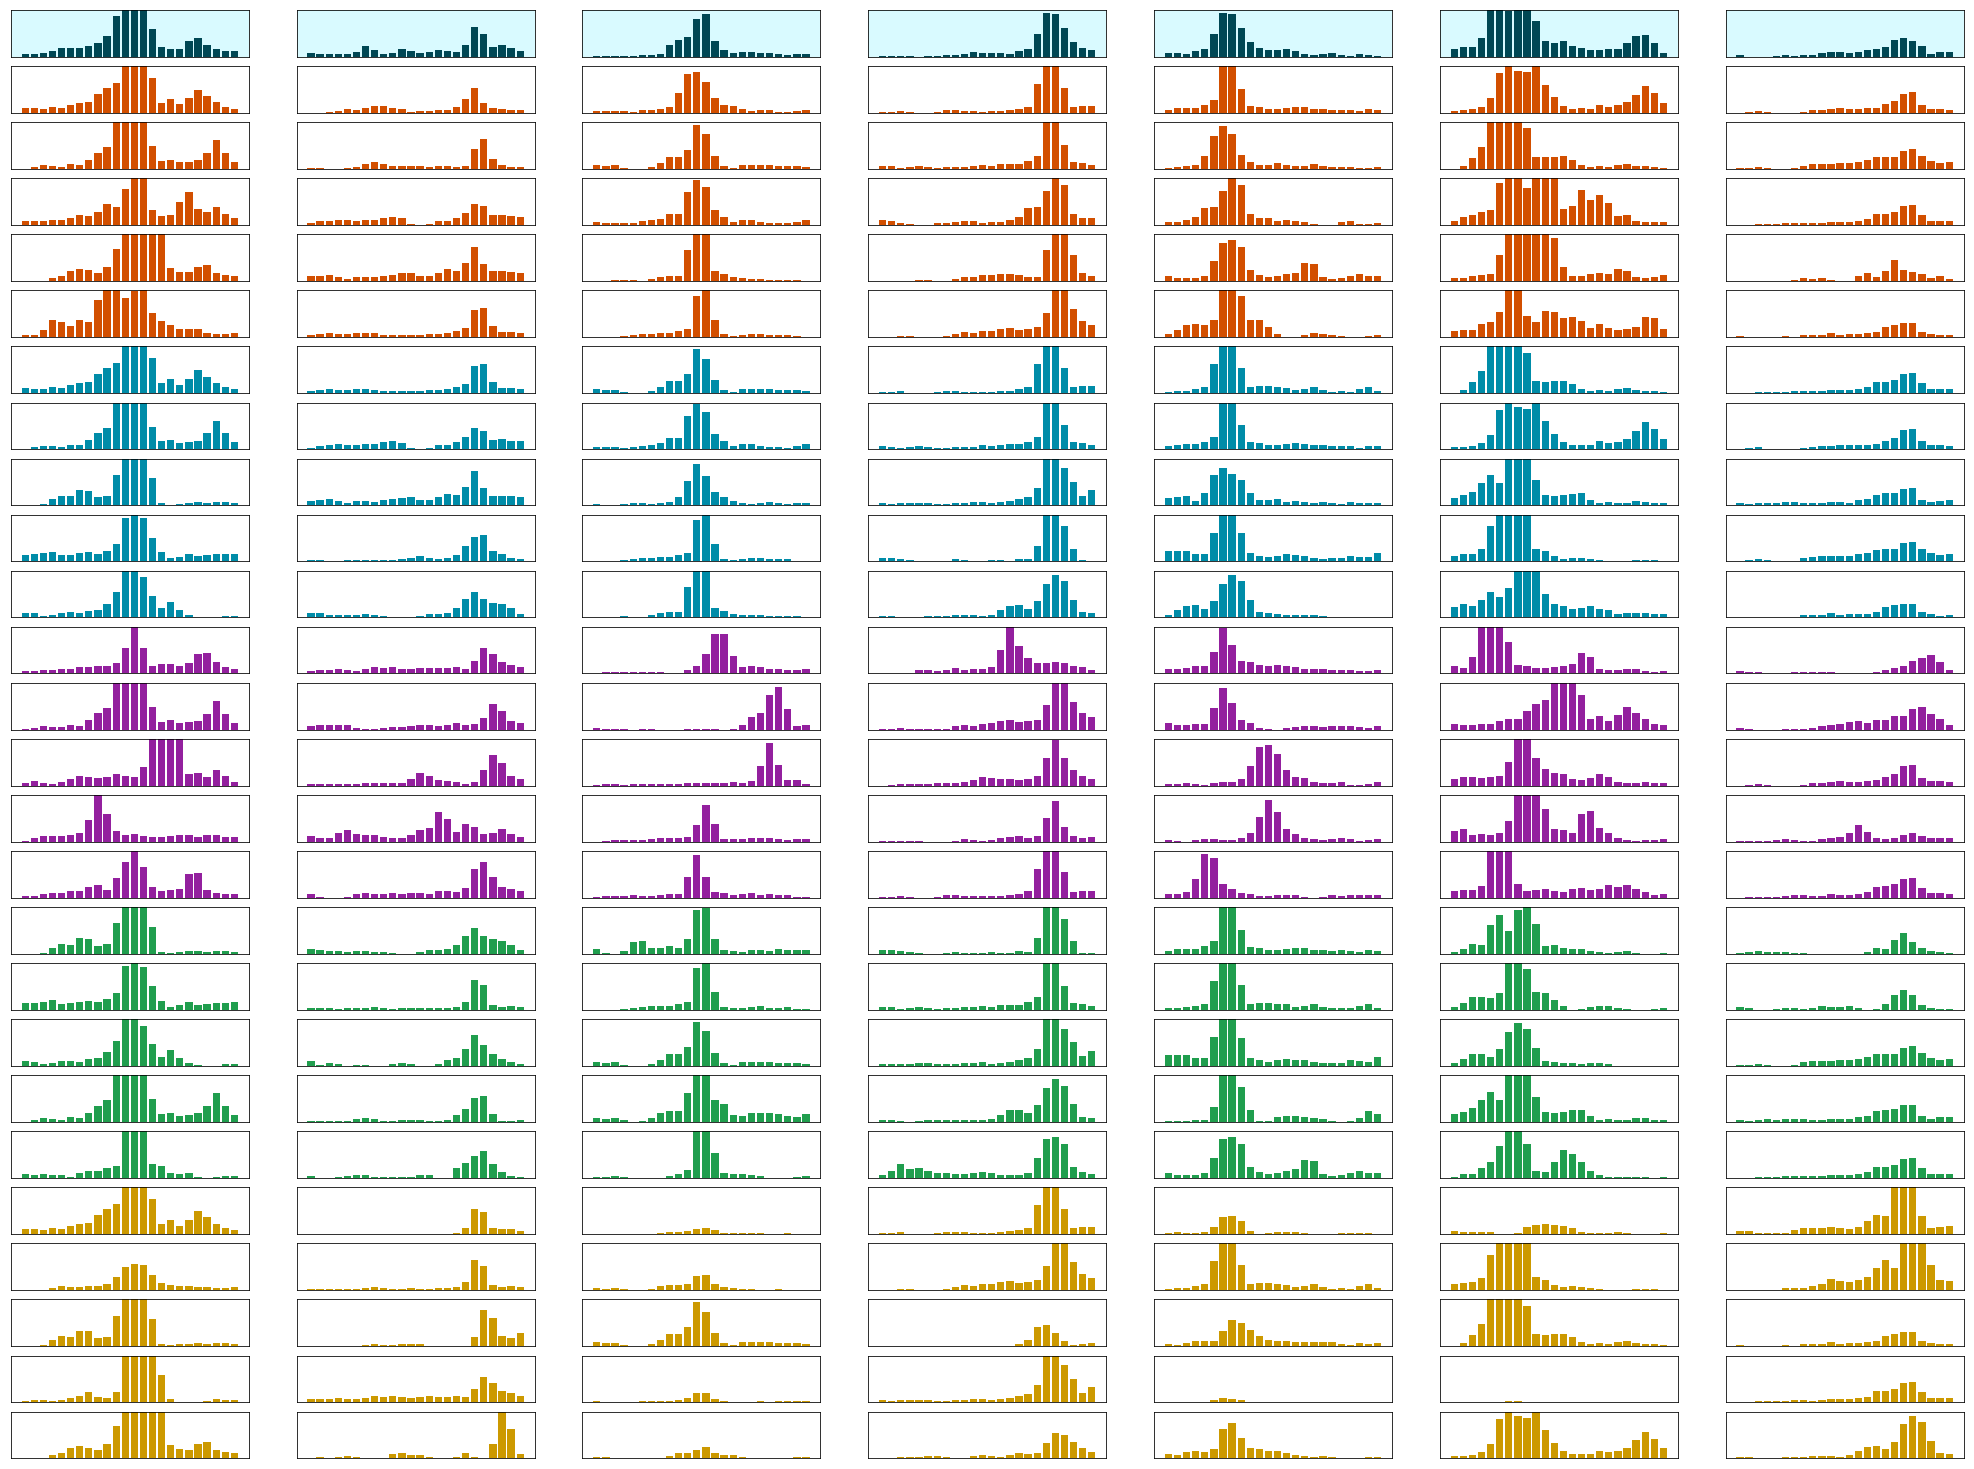

In [139]:
import matplotlib.pyplot as plt 
import numpy as np

N = (k + 1) * 6

T = len(targets)
sz = data_test[0].size

plt.figure(figsize=(5 * T, N))

ymax = 1.0

show_predictions = False

for i, target in enumerate(targets):
    ax = plt.subplot(N, T, (i + 1))
        
    ax.set_facecolor("#D9FAFF")
    
    if show_predictions:
        plt.bar(np.arange(sz), data_test[target], color='black', alpha=0.33)
        plt.bar(np.arange(sz), data_test[target], color='black', alpha=0.33)
    else:
        plt.bar(np.arange(sz), data_test[target], color='#004754')

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_ae[i]):
        plt.subplot(N, T, ((j + 1) * T) + (i + 1))
        if show_predictions:
            plt.bar(np.arange(sz), predicted[hit], color='green', alpha=0.33)
            plt.bar(np.arange(sz), data_test[hit], color='black', alpha=0.33)
        else:
            plt.bar(np.arange(sz), data_test[hit], color='#d24f00')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(knn_eq[i]):
        plt.subplot(N, T, ((j + 6) * T) + (i + 1))
        if show_predictions:
            plt.bar(np.arange(sz), predicted[hit], color='green', alpha=0.33)
            plt.bar(np.arange(sz), data_test[hit], color='black', alpha=0.33)
        else:
            plt.bar(np.arange(sz), data_test[hit], color='#008ca8')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_dtw[i]):
        plt.subplot(N, T, ((j + 11) * T) + (i + 1))
        if show_predictions:
            plt.bar(np.arange(sz), predicted[hit], color='red', alpha=0.33)
            plt.bar(np.arange(sz), data_test[hit], color='black', alpha=0.33)
        else:
            plt.bar(np.arange(sz), data_test[hit], color='#93209e')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_umap[i]):
        plt.subplot(N, T, ((j + 16) * T) + (i + 1))
        if show_predictions:
            plt.bar(np.arange(sz), predicted[hit], color='yellow', alpha=0.33)
            plt.bar(np.arange(sz), data_test[hit], color='black')
        else:
            plt.bar(np.arange(sz), data_test[hit], color='#209e4e')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(top_xcross[i]):
        plt.subplot(N, T, ((j + 21) * T) + (i + 1))
        plt.bar(np.arange(sz), data_test[hit], color='#cc9900')
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

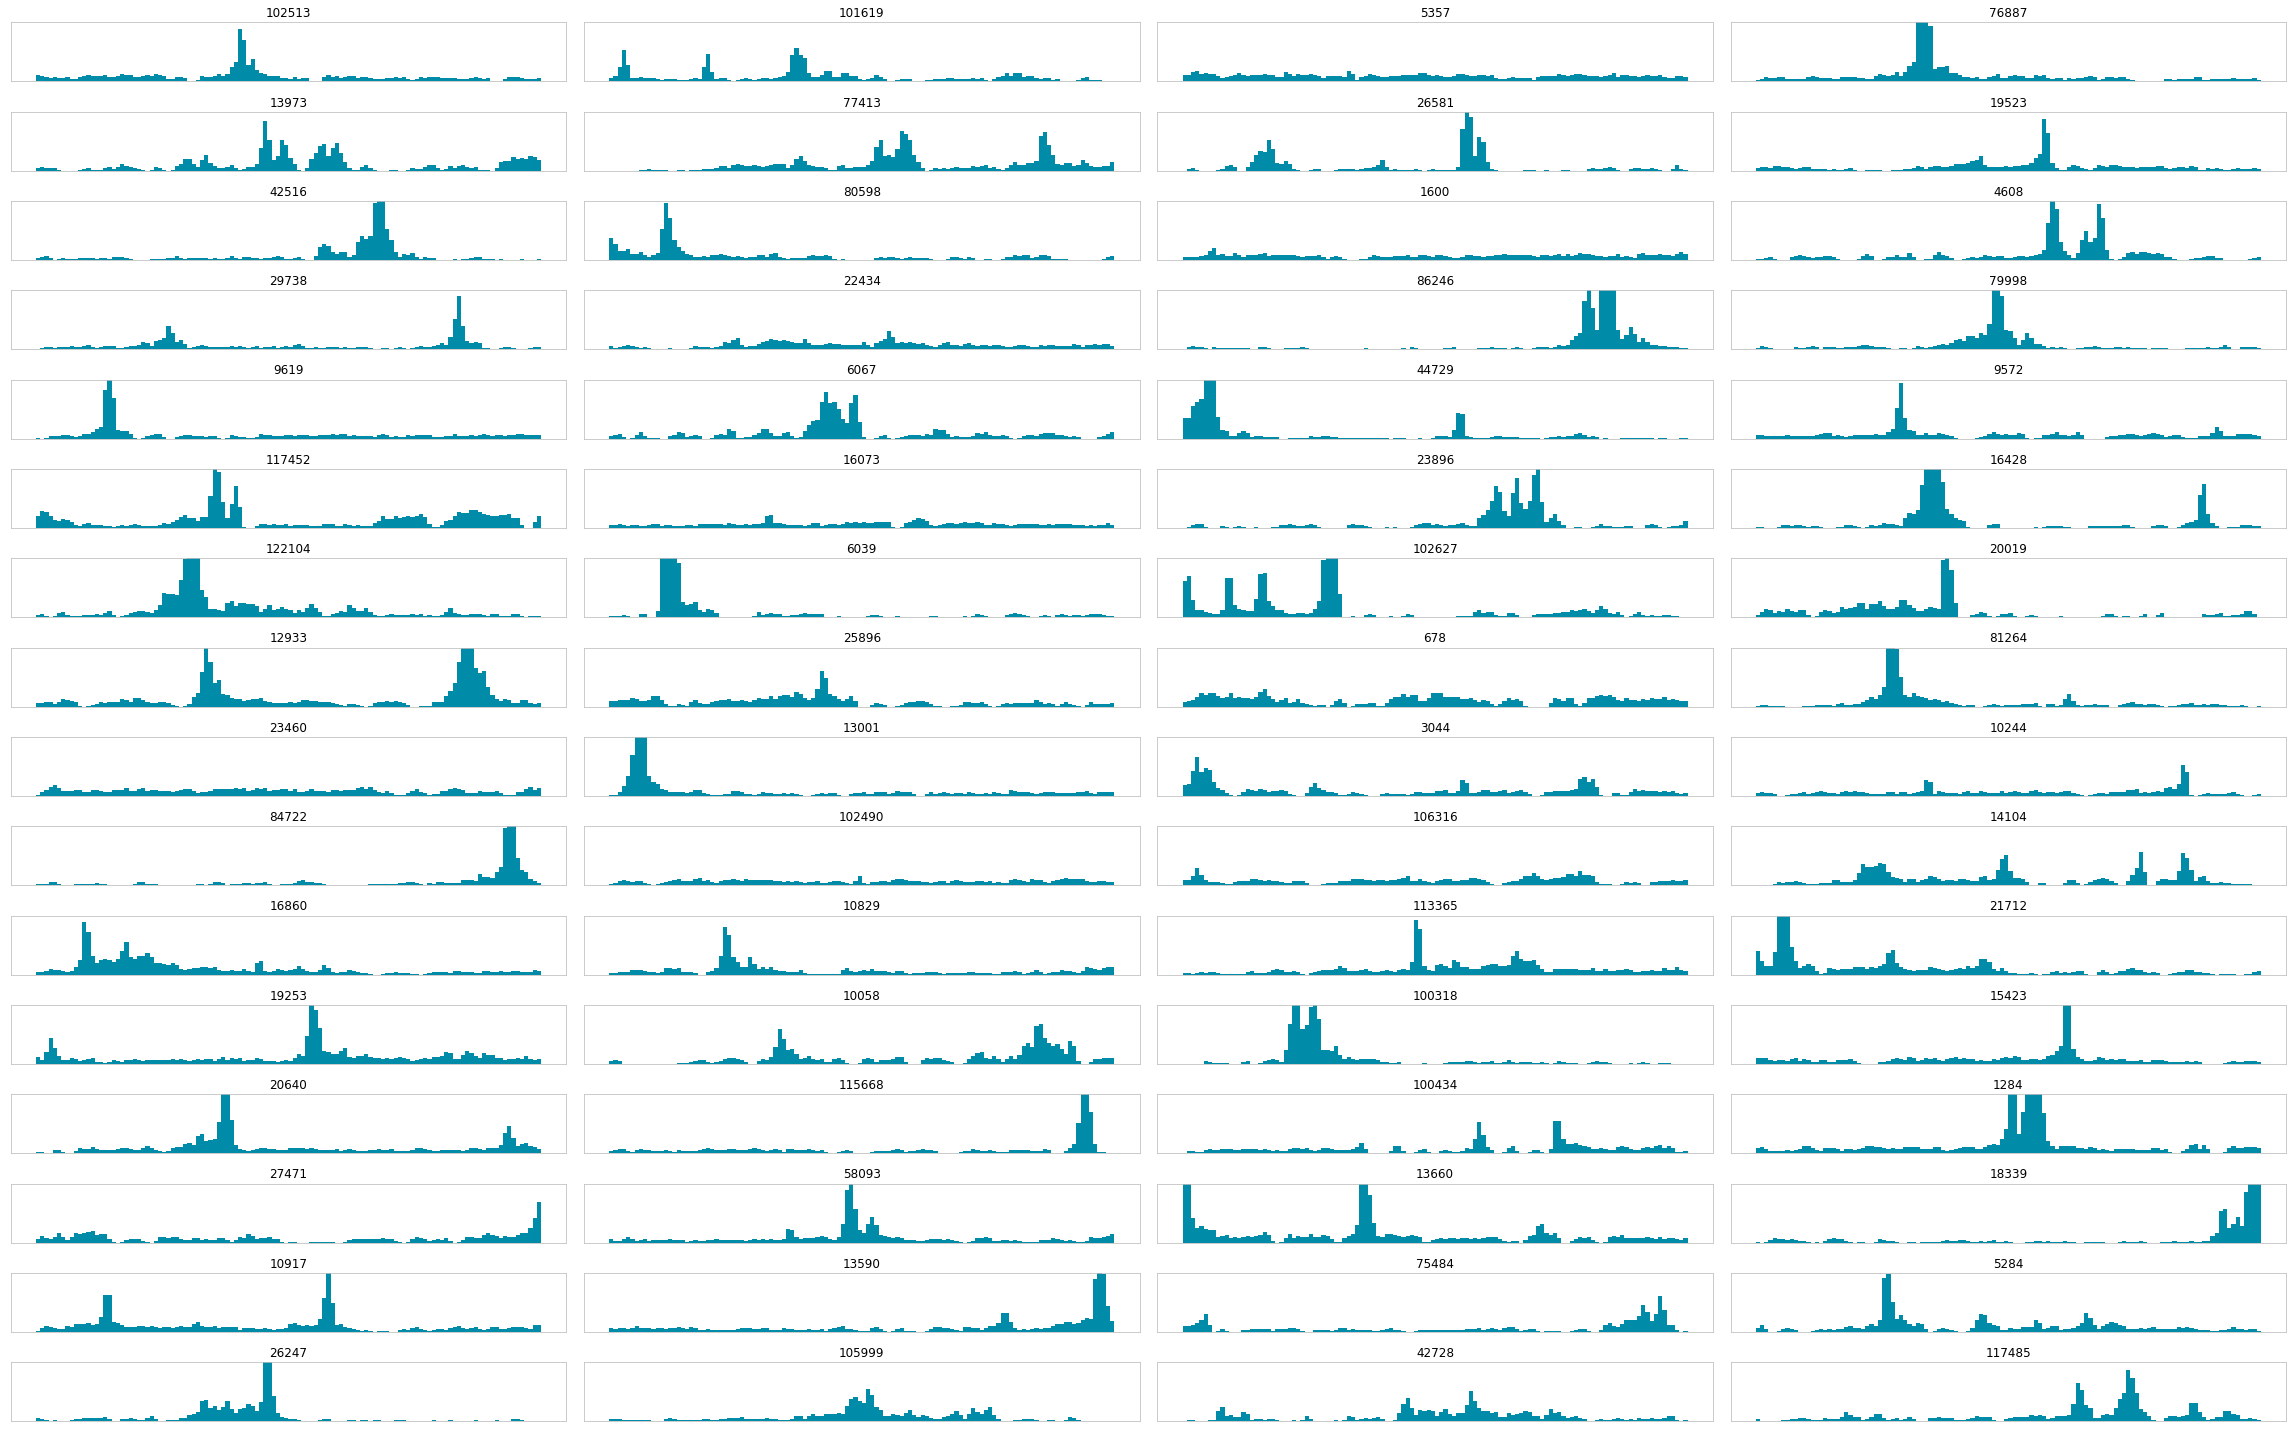

In [178]:
from ae.utils import plot_windows_from_data

num_windows = 64
min_signal = 8

plot_windows_from_data(
    data_12kb,
    num=num_windows,
    min_signal=min_signal,
)

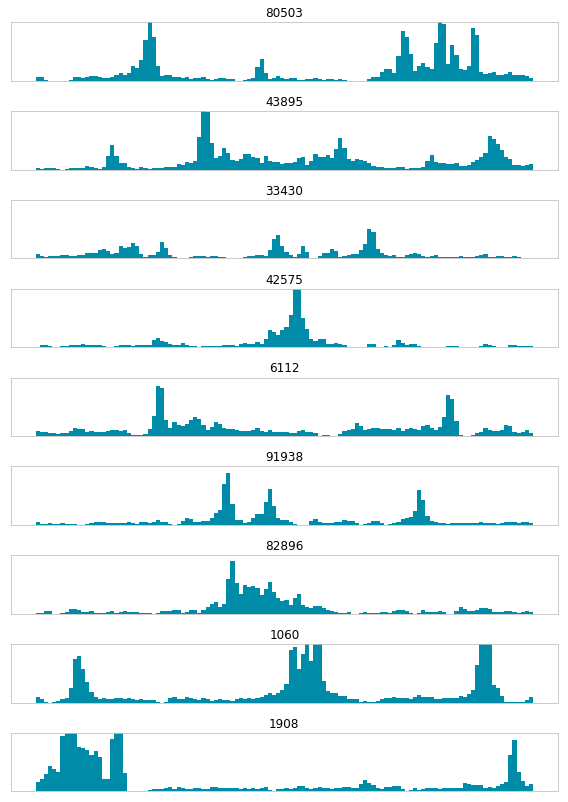

In [174]:
plot_windows_from_data(data_12kb, window_ids=[80503, 43895, 33430, 42575, 6112, 91938, 82896, 1060, 11975])

## 12kb search

In [388]:
import umap

umap_embedding_12kb = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    metric='l2',
    n_components=10,
).fit_transform(data_12kb)

In [389]:
"""Update UMAP only"""

k_12kb = 10
knn_umap = []

for target in targets_12kb:
    print('Search for window #{}'.format(target), end='', flush=True)
    knn_umap.append(knn(umap_embedding_12kb, target, k))
    print('. done!')

Search for window #80503. done!
Search for window #43895. done!
Search for window #33430. done!
Search for window #42575. done!
Search for window #6112. done!
Search for window #91938. done!
Search for window #82896. done!
Search for window #1060. done!
Search for window #11975. done!


In [346]:
from tslearn.piecewise import SymbolicAggregateApproximation

sax_12kb = SymbolicAggregateApproximation(n_segments=120, alphabet_size_avg=10)
sax_data_12kb = sax_12kb.fit_transform(data_12kb)

In [203]:
from time import time

# Some genomic windows with interesting peaks
targets_12kb = [80503, 43895, 33430, 42575, 6112, 91938, 82896, 1060, 11975]
k_12kb = 10

knn_ae = []
knn_eq = []
knn_dtw = []
knn_umap = []
top_xcross = []

for target in targets_12kb:
    t0 = time()
    print('Search for window #{}'.format(target), end='', flush=True)
    knn_ae.append(knn(latent_12kb, target, k))
    print('.', end='', flush=True)
    knn_eq.append(knn(data_12kb, target, k))
    print('.', end='', flush=True)
    knn_umap.append(knn(umap_embedding_12kb, target, k))
    print('.', end='', flush=True)
    top_xcross.append(xcrorrelation(data_12kb, target, k, normalize=True, zero_normalize=True))
    print('.', end='', flush=True)
    knn_dtw.append(pooled_dtw(data_12kb, target, k))
    print('. done! ({:.2f} sec)'.format(time() - t0))

Search for window #80503..... done! (1417.16 sec)
Search for window #43895..... done! (2566.89 sec)
Search for window #33430..... done! (1443.00 sec)
Search for window #42575..... done! (1400.71 sec)
Search for window #6112..... done! (1452.21 sec)
Search for window #91938..... done! (1421.98 sec)
Search for window #82896..... done! (1498.53 sec)
Search for window #1060..... done! (1467.06 sec)
Search for window #11975..... done! (1446.01 sec)


In [347]:
knn_sax = []
for target in targets_12kb:
    t0 = time()
    print('Search for window #{}'.format(target), end='', flush=True)
    knn_sax.append(knn(sax_data_12kb, target, k, sax=sax_12kb))
    print('. done! ({:.2f} sec)'.format(time() - t0))

Search for window #80503. done! (16.09 sec)
Search for window #43895. done! (14.81 sec)
Search for window #33430. done! (14.14 sec)
Search for window #42575. done! (14.41 sec)
Search for window #6112. done! (15.33 sec)
Search for window #91938. done! (14.28 sec)
Search for window #82896. done! (14.42 sec)
Search for window #1060. done! (15.91 sec)
Search for window #11975. done! (15.26 sec)


In [ ]:
with open('data/knn_12kb.json', 'r') as f:
    knn_12kb = json.load(f)
    
knn_ae = np.array(knn_12kb['knnAe'])
knn_eq = np.array(knn_12kb['knnEq'])
knn_dtw = np.array(knn_12kb['knnDtw'])
knn_umap = np.array(knn_12kb['knnUmap'])
top_xcross = np.array(knn_12kb['topXcross'])

In [399]:
import json

knn_12kb = {
    "targets": targets_12kb,
    "knnAe": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_ae],
    "knnEq": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_eq],
    "knnUmap": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_umap],
    "topXcross": [x.tolist() if hasattr(x, 'tolist') else x for x in top_xcross],
    "knnDtw": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_dtw],
    "knnSax": [x.tolist() if hasattr(x, 'tolist') else x for x in knn_sax],
}

with open('data/knn_12kb.json', 'w') as f:
    json.dump(knn_12kb, f)

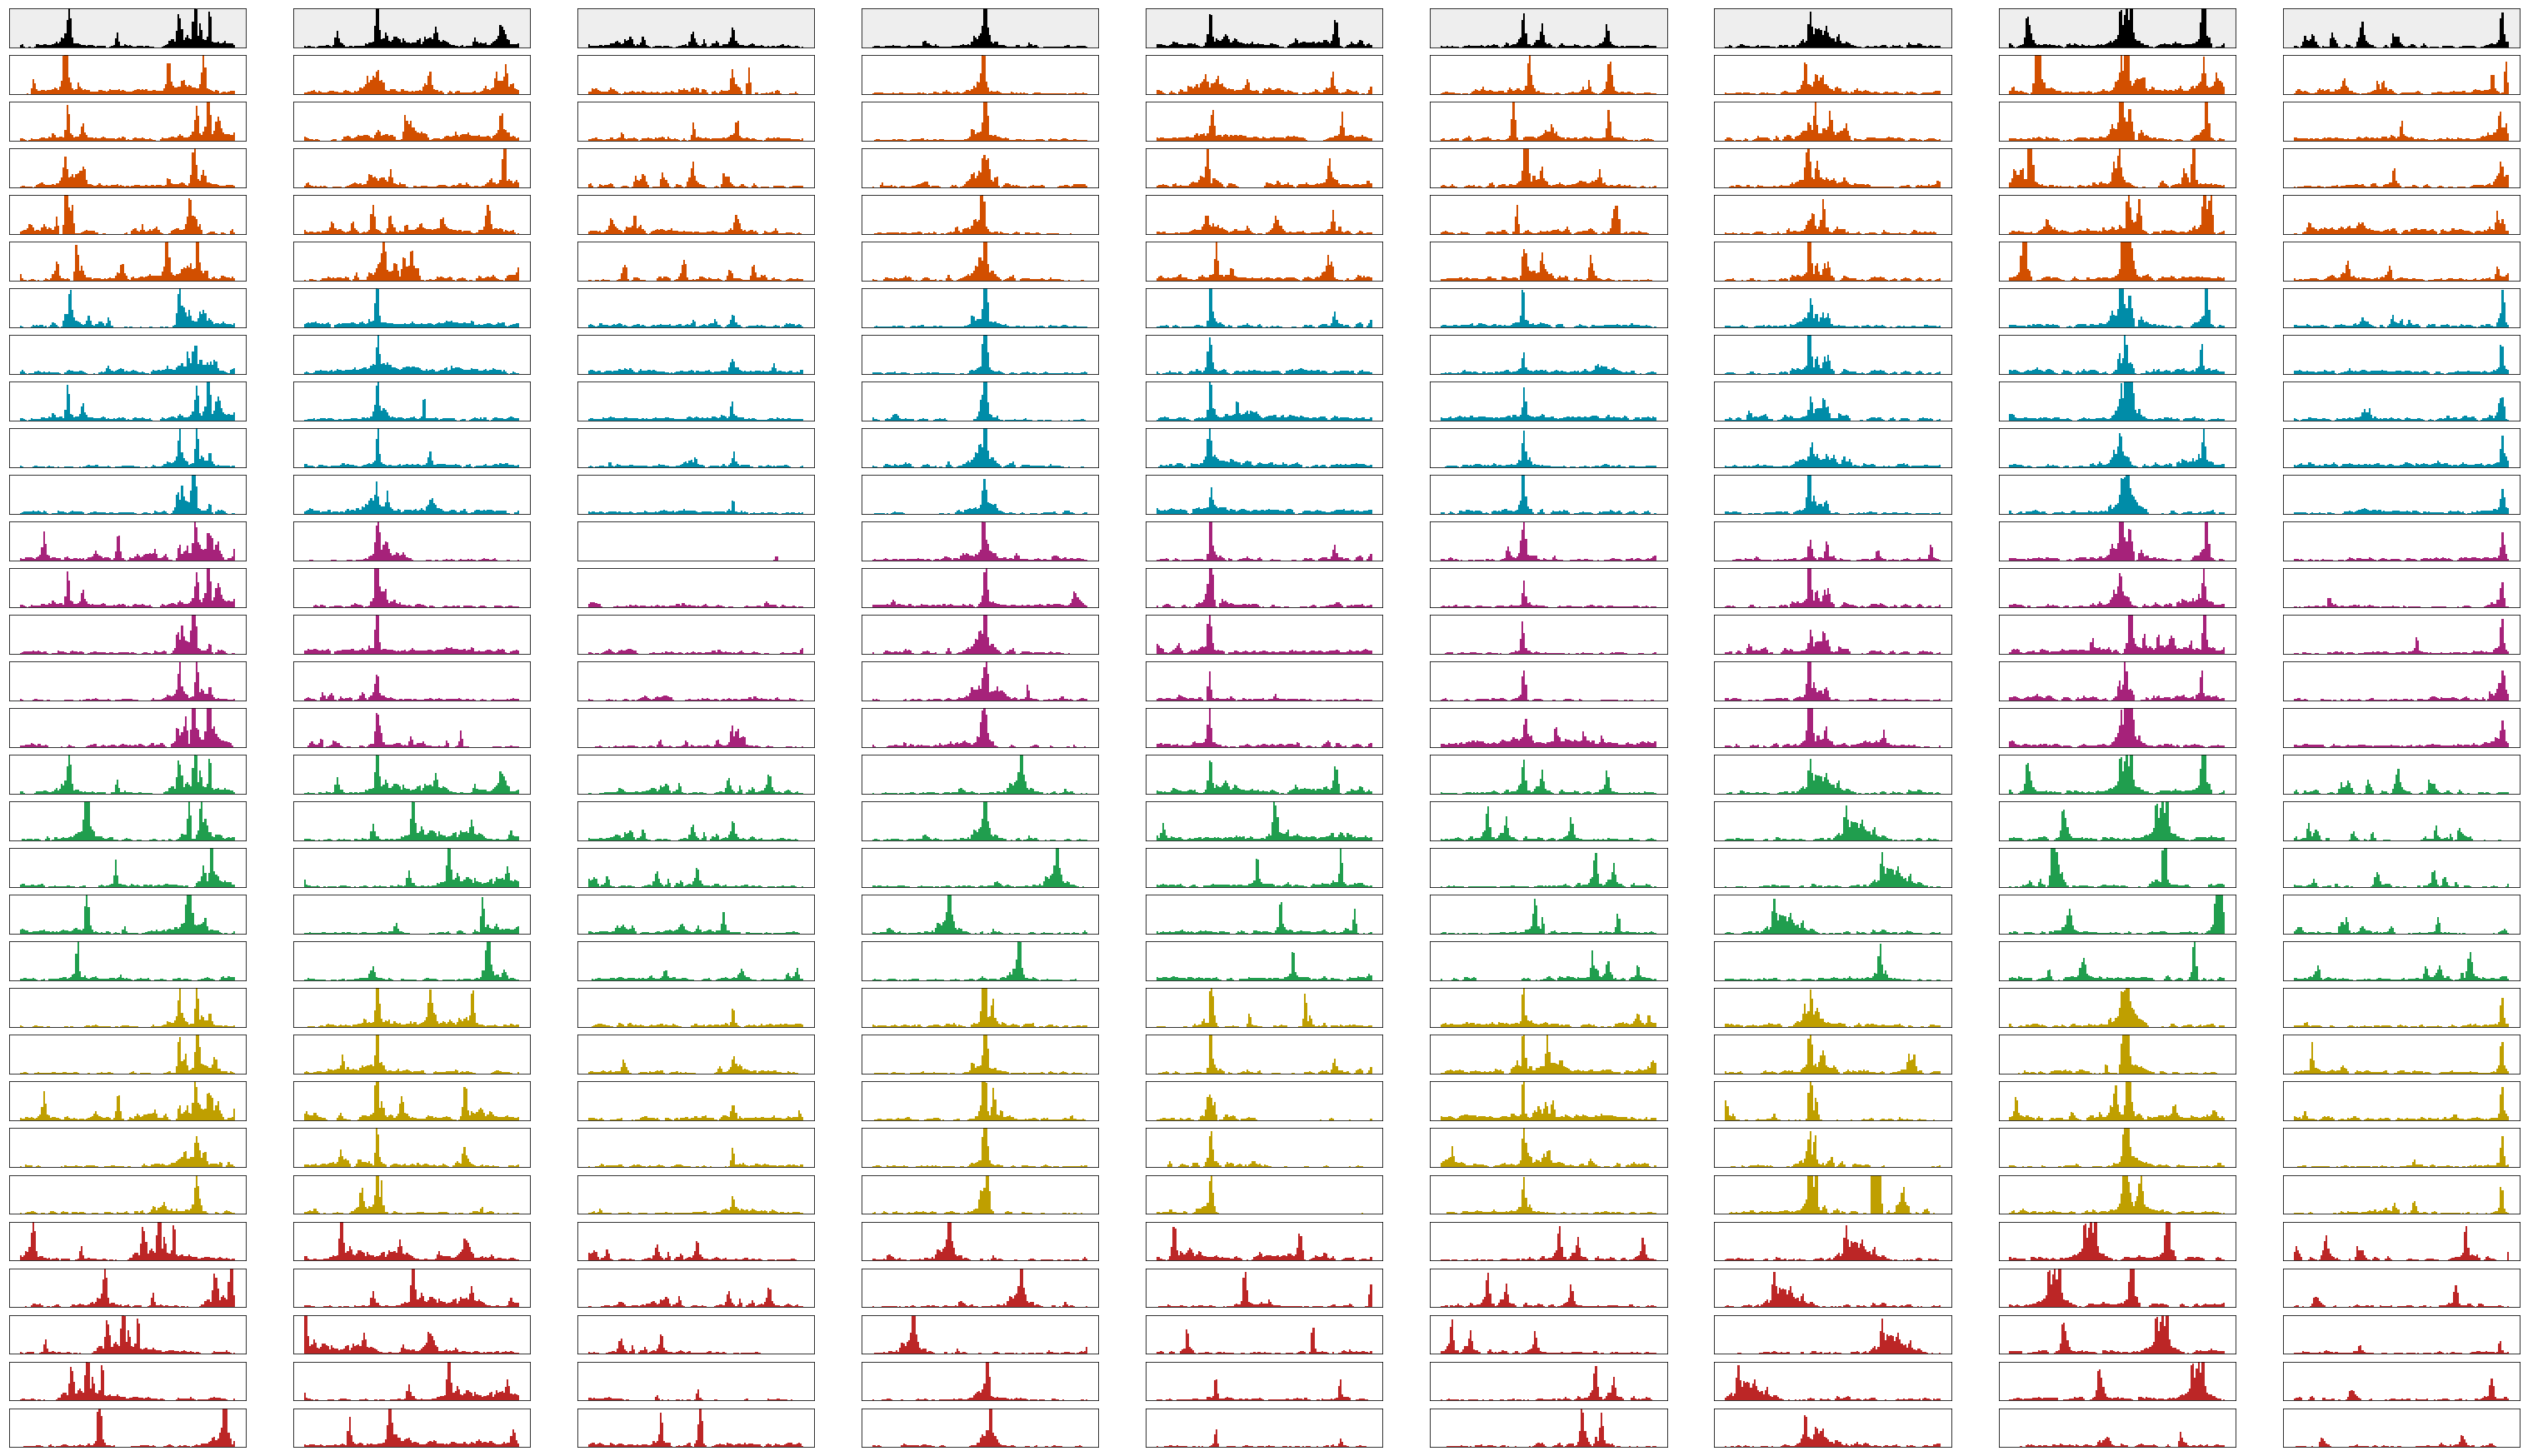

In [400]:
import matplotlib.pyplot as plt 
import numpy as np
import json


with open('data/knn_12kb.json', 'r') as f:
    knn_12kb = json.load(f)
    
k_12kb = len(knn_12kb["knnAe"][0])
targets_12kb = knn_12kb["targets"]
knn_ae = knn_12kb["knnAe"]
knn_eq = knn_12kb["knnEq"]
knn_umap = knn_12kb["knnUmap"]
knn_dtw = knn_12kb["knnDtw"]
top_xcross = knn_12kb["topXcross"]
knn_sax = knn_12kb["knnSax"]

N = (k_12kb + 1) * 7

T = len(targets_12kb)
sz = data_12kb[0].size

plt.figure(figsize=(6 * T, N))

ymax = 1.0

show_predictions = False

for i, target in enumerate(targets):
    ax = plt.subplot(N, T, (i + 1))
        
    ax.set_facecolor("#D9FAFF")
    ax.set_facecolor("#eeeeee")
    
    if show_predictions:
        plt.bar(np.arange(sz), predicted_12kb[target], color='black', alpha=0.33)
        plt.bar(np.arange(sz), data_12kb[target], color='black', alpha=0.33)
    else:
        plt.bar(np.arange(sz), data_12kb[target], color='#004754', width=1.0)
        plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_ae[i]):
        plt.subplot(N, T, ((j + 1) * T) + (i + 1))
        if show_predictions:
        plt.bar(np.arange(sz), data_12kb[hit], color='#d24f00', width=1.0) # orange = CAE
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(knn_eq[i]):
        plt.subplot(N, T, ((j + 6) * T) + (i + 1))
        if show_predictions:
        plt.bar(np.arange(sz), data_12kb[hit], color='#008ca8', width=1.0) # blue = EQ
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_sax[i]):
        plt.subplot(N, T, ((j + 11) * T) + (i + 1))
        if show_predictions:
        plt.bar(np.arange(sz), data_12kb[hit], color='#a6227a', width=1.0) # purple = SAX
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_dtw[i]):
        plt.subplot(N, T, ((j + 16) * T) + (i + 1))
        if show_predictions:
        plt.bar(np.arange(sz), data_12kb[hit], color='#209e4e', width=1.0) # green = DTW
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_umap[i]):
        plt.subplot(N, T, ((j + 21) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#bf9f00', width=1.0) # yellow = UMAP
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(top_xcross[i]):
        plt.subplot(N, T, ((j + 26) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#bc2626', width=1.0) # red = Zero-nornalized X correlation
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

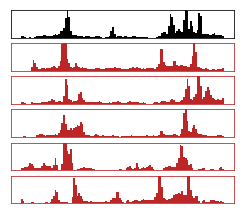

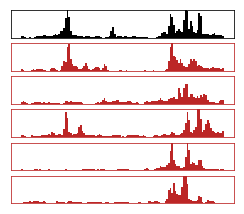

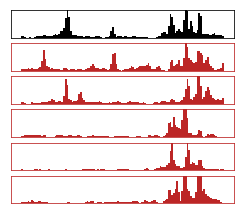

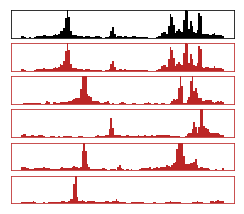

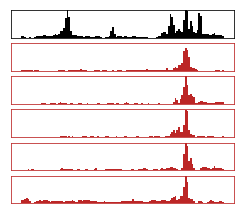

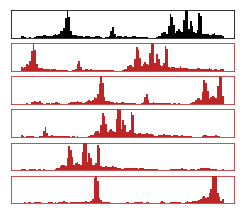

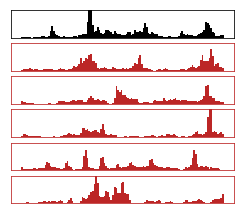

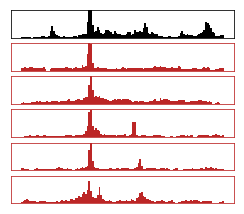

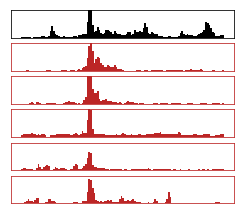

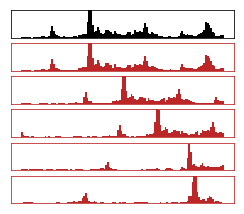

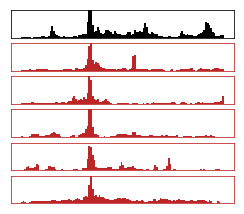

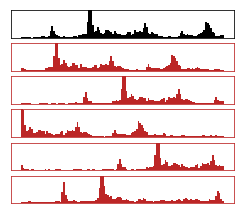

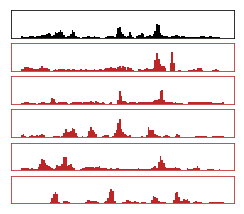

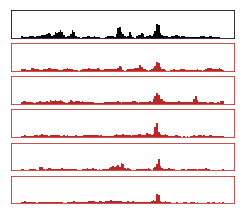

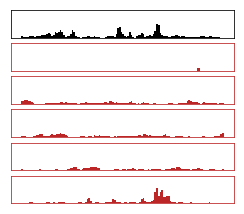

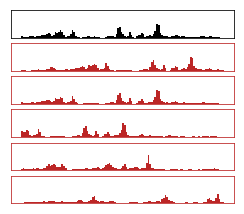

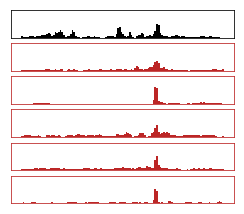

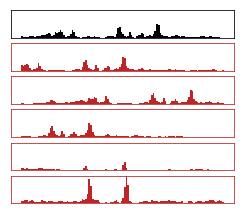

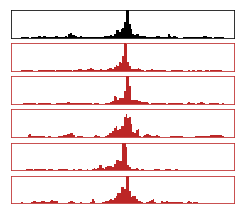

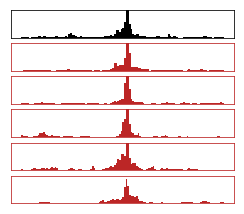

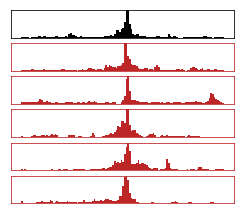

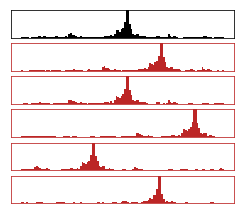

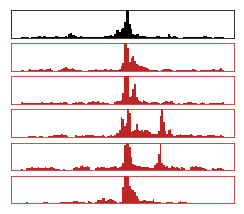

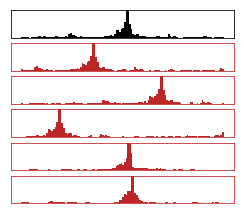

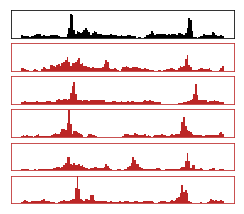

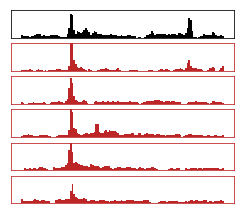

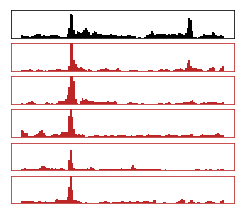

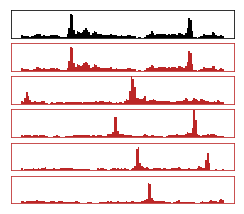

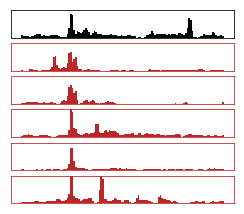

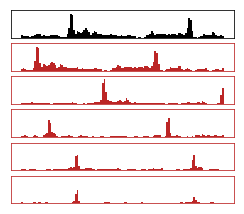

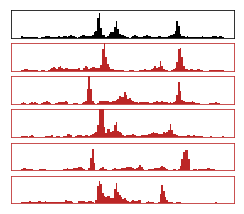

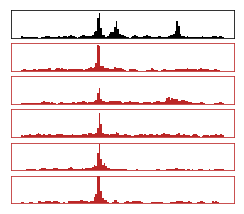

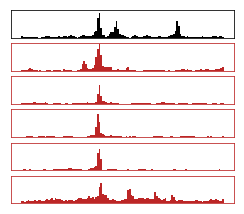

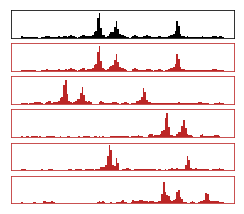

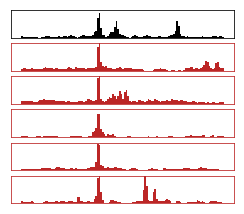

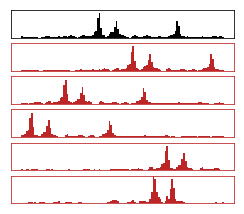

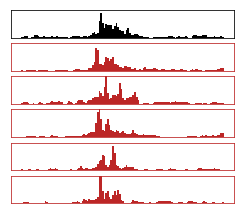

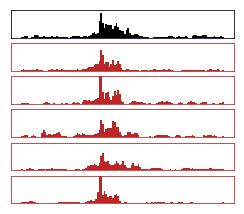

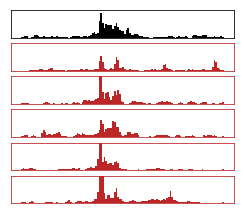

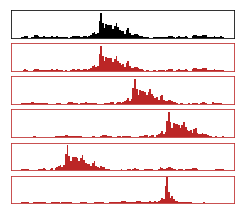

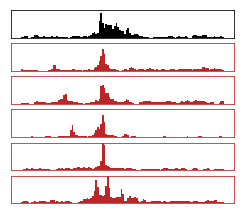

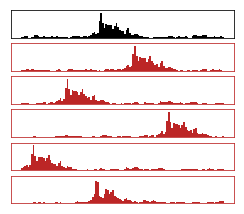

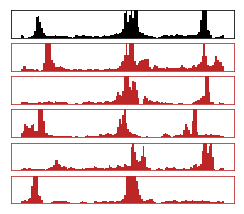

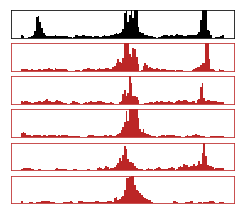

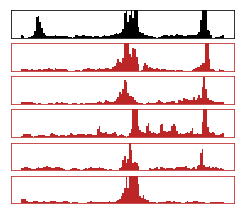

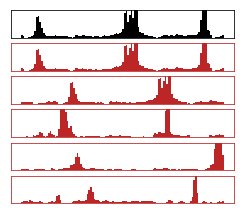

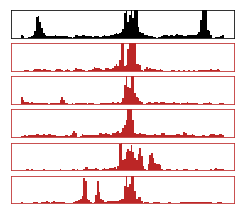

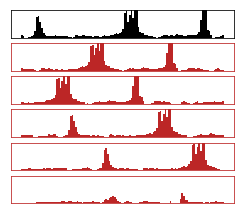

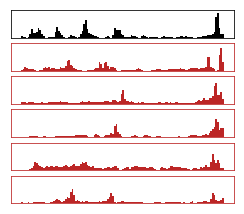

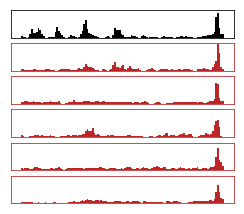

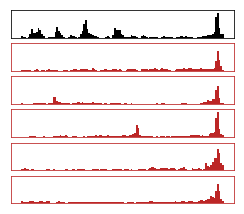

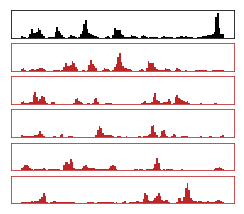

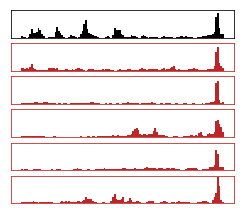

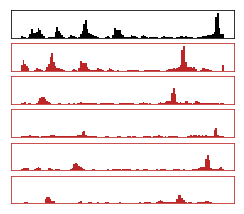

In [387]:
import matplotlib.pyplot as plt 
import numpy as np
import json


with open('data/knn_12kb.json', 'r') as f:
    knn_12kb = json.load(f)
    
k_12kb = len(knn_12kb["knnAe"][0])
targets_12kb = knn_12kb["targets"]
knn_ae = knn_12kb["knnAe"]
knn_eq = knn_12kb["knnEq"]
knn_umap = knn_12kb["knnUmap"]
knn_dtw = knn_12kb["knnDtw"]
top_xcross = knn_12kb["topXcross"]
knn_sax = knn_12kb["knnSax"]

N = (k_12kb + 1) * 7

T = len(targets_12kb)
sz = data_12kb[0].size

ymax = 1.0

show_predictions = False

knn_color = '#bc2626'

for i, target in enumerate(targets):
    fig = plt.figure(figsize=(4, (k_12kb + 1) * 4.25))
    ax = plt.subplot(N, 1, 1)

    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_ae[i]):
        plt.subplot(N, 1, (j + 2))
        plt.bar(np.arange(sz), data_12kb[hit], color=knn_color, width=1.0)
        ax = plt.gca()
        ax.spines["top"].set_color(knn_color)
        ax.spines["right"].set_color(knn_color)
        ax.spines["bottom"].set_color(knn_color)
        ax.spines["left"].set_color(knn_color)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        
    fig.savefig('../mturk/12KB-T{}A.png'.format(i), bbox_inches="tight", pad_inches=0)
        
    plt.figure(figsize=(4, (k_12kb + 1) * 4.25))
    ax = plt.subplot(N, 1, 1)

    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_eq[i]):
        plt.subplot(N, 1, (j + 2))
        plt.bar(np.arange(sz), data_12kb[hit], color=knn_color, width=1.0)
        ax = plt.gca()
        ax.spines["top"].set_color(knn_color)
        ax.spines["right"].set_color(knn_color)
        ax.spines["bottom"].set_color(knn_color)
        ax.spines["left"].set_color(knn_color)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        
    plt.savefig('../mturk/12KB-T{}B.png'.format(i), bbox_inches="tight", pad_inches=0)
        
    plt.figure(figsize=(4, (k_12kb + 1) * 4.25))
    ax = plt.subplot(N, 1, 1)

    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_sax[i]):
        plt.subplot(N, 1, (j + 2))
        plt.bar(np.arange(sz), data_12kb[hit], color=knn_color, width=1.0)
        ax = plt.gca()
        ax.spines["top"].set_color(knn_color)
        ax.spines["right"].set_color(knn_color)
        ax.spines["bottom"].set_color(knn_color)
        ax.spines["left"].set_color(knn_color)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        
    plt.savefig('../mturk/12KB-T{}C.png'.format(i), bbox_inches="tight", pad_inches=0)
        
    plt.figure(figsize=(4, (k_12kb + 1) * 4.25))
    ax = plt.subplot(N, 1, 1)

    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_dtw[i]):
        plt.subplot(N, 1, (j + 2))
        plt.bar(np.arange(sz), data_12kb[hit], color=knn_color, width=1.0)
        ax = plt.gca()
        ax.spines["top"].set_color(knn_color)
        ax.spines["right"].set_color(knn_color)
        ax.spines["bottom"].set_color(knn_color)
        ax.spines["left"].set_color(knn_color)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        
    plt.savefig('../mturk/12KB-T{}D.png'.format(i), bbox_inches="tight", pad_inches=0)
        
    plt.figure(figsize=(4, (k_12kb + 1) * 4.25))
    ax = plt.subplot(N, 1, 1)

    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_umap[i]):
        plt.subplot(N, 1, (j + 2))
        plt.bar(np.arange(sz), data_12kb[hit], color=knn_color, width=1.0)
        ax = plt.gca()
        ax.spines["top"].set_color(knn_color)
        ax.spines["right"].set_color(knn_color)
        ax.spines["bottom"].set_color(knn_color)
        ax.spines["left"].set_color(knn_color)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        
    plt.savefig('../mturk/12KB-T{}E.png'.format(i), bbox_inches="tight", pad_inches=0)
        
    plt.figure(figsize=(4, (k_12kb + 1) * 4.25))
    ax = plt.subplot(N, 1, 1)

    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(top_xcross[i]):
        plt.subplot(N, 1, (j + 2))
        plt.bar(np.arange(sz), data_12kb[hit], color='#bc2626', width=1.0)
        ax = plt.gca()
        ax.spines["top"].set_color("#bc2626")
        ax.spines["right"].set_color("#bc2626")
        ax.spines["bottom"].set_color("#bc2626")
        ax.spines["left"].set_color("#bc2626")
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        
    plt.savefig('../mturk/12KB-T{}F.png'.format(i), bbox_inches="tight", pad_inches=0)